In [4]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.13.0


In [8]:
train_data = pd.read_csv('./Datasets/House Prices/train.csv')
test_data = pd.read_csv('./Datasets/House Prices/test.csv')

print(train_data.shape)
print(test_data.shape)
all_features = pd.concat((train_data.iloc[:, 1:-1],
test_data.iloc[:, 1:]))

(1460, 81)
(1459, 80)


In [9]:
numeric_features = all_features.dtypes[all_features.dtypes !=
'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个特征的均值变为0，所以可以直接⽤用0来替换缺失值
all_features = all_features.fillna(0)

In [10]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape # (2919, 354)

(2919, 354)

In [11]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,
dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,
dtype=torch.float).view(-1, 1)

In [12]:
loss = torch.nn.MSELoss()
def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [13]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将⼩小于1的值设成1，使得取对数时数值更更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(),
labels.log()).mean())
    return rmse.item()

In [14]:
def train(net, train_features, train_labels, test_features,
test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features,
train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size,
shuffle=True)
    # 这⾥里里使⽤用了了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(),
lr=learning_rate, weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features,
train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features,
test_labels))
    return train_ls, test_ls

In [15]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [16]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs,
learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls,
'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i,
train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.240102, valid rmse 0.221314
fold 1, train rmse 0.229611, valid rmse 0.268734
fold 2, train rmse 0.231457, valid rmse 0.238002
fold 3, train rmse 0.237047, valid rmse 0.218276
fold 4, train rmse 0.230096, valid rmse 0.258054
5-fold validation: avg train rmse 0.233662, avg valid rmse 0.240876


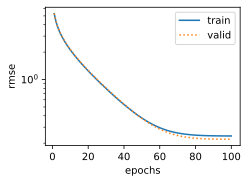

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels,
num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' %
(k, train_l, valid_l))